## General information

This notebook is the final project in the Workshop In Data Science course at Tel-Aviv university on 2018/19 academic year. 
The goal of this project is to predict Major League Baseball game attendance.
It contains all phases of the project - from cleaning to evaluation.

The project was done by:
Ran Erez, 
Eidan Wasser, 
Elkana Gamliel and
Dana Rapoport

![](https://upload.wikimedia.org/wikipedia/commons/9/98/Angels_Stadium.JPG)

### Importing libraries and getting data

In [1]:
from feature_engineering import *
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean, std
import numpy.ma as ma
import csv
import math
import copy
from bisect import bisect_left as bisect
!pip install tqdm
from tqdm import tqdm
from IPython.display import HTML
from collections import defaultdict
from datetime import date, datetime
import seaborn as sns
from pandas.api.types import CategoricalDtype
from pandas.tools import plotting
from pandas.plotting import scatter_matrix
from scipy import stats
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import feature_selection
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [3]:
data = pd.read_csv("GL1990_2017.csv")

## Dataset analysis

We have a really interesting dataset which contains MLB log games between 1990 to 2017!
Now let's have a look at the data itself. We can see trends, distributions and correlations.

In [4]:
pd.set_option('display.max_columns', 200)
data.head()

,season,date,number_of_game,day_of_week,visiting_team,visiting_team_league,visiting_team_game_number,home_team,home_team_league,home_team_game_number,visiting_team_runs,home_team_runs,game_time,completion_info,park_id,attendance,visiting_team_hits,visiting_team_home_runs,home_team_hits,home_team_home_runs,winning_pitcher_id,winning_pitcher_name,losing_pitcher_id,losing_pitcher_name,saving_pitcher_id,saving_pitcher_name,game_winning_rbi_batter_id,game_winning_rbi_batter_name,visiting_pitcher_id,visiting_pitcher_name,home_pitcher_id,home_pitcher_name,visiting_player1_id,visiting_player1_name,visiting_player1_pos,visiting_player2_id,visiting_player2_name,visiting_player2_pos,visiting_player3_id,visiting_player3_name,visiting_player3_pos,visiting_player4_id,visiting_player4_name,visiting_player4_pos,visiting_player5_id,visiting_player5_name,visiting_player5_pos,visiting_player6_id,visiting_player6_name,visiting_player6_pos,visiting_player7_id,visiting_player7_name,visiting_player7_pos,visiting_player8_id,visiting_player8_name,visiting_player8_pos,visiting_player9_id,visiting_player9_name,visiting_player9_pos,home_player1_id,home_player1_name,home_player1_pos,home_player2_id,home_player2_name,home_player2_pos,home_player3_id,home_player3_name,home_player3_pos,home_player4_id,home_player4_name,home_player4_pos,home_player5_id,home_player5_name,home_player5_pos,home_player6_id,home_player6_name,home_player6_pos,home_player7_id,home_player7_name,home_player7_pos,home_player8_id,home_player8_name,home_player8_pos,home_player9_id,home_player9_name,home_player9_pos,acquisition_info
0,1990,4/9/1990,0,Mon,DET,AL,1,BOS,AL,1,2,5,D,NaN,BOS07,35199.0,5,0,8,0,clemr001,Roger Clemens,morrj001,Jack Morris,smitl001,Lee Smith,evand002,Dwight Evans,morrj001,Jack Morris,clemr001,Roger Clemens,philt001,Tony Phillips,5,trama001,Alan Trammell,6,whitl001,Lou Whitaker,4,fielc001,Cecil Fielder,3,mosel001,Lloyd Moseby,8,nokem001,Matt Nokes,2,wardg001,Gary Ward,7,lemoc001,Chet Lemon,9,bergd001,Dave Bergman,10,boggw001,Wade Boggs,5,barrm001,Marty Barrett,4,greem001,Mike Greenwell,7,burke001,Ellis Burks,8,evand002,Dwight Evans,10,robib001,Billy Jo Robidoux,3,penat001,Tony Pena,2,reedj003,Jody Reed,6,romik001,Kevin Romine,9,Y
1,1990,4/9/1990,0,Mon,SEA,AL,1,CAL,AL,1,7,4,N,NaN,ANA01,38406.0,15,1,5,1,holmb001,Brian Holman,blylb001,Bert Blyleven,schom001,Mike Schooler,grifk002,Ken Griffey,holmb001,Brian Holman,blylb001,Bert Blyleven,reynh001,Harold Reynolds,4,grifk002,Ken Griffey,8,davia002,Alvin Davis,10,leonj001,Jeffrey Leonard,9,obrip001,Pete O'Brien,3,brilg001,Greg Briley,7,marte001,Edgar Martinez,5,valld001,Dave Valle,2,gileb001,Brian Giles,6,whitd001,Devon White,8,ray-j001,Johnny Ray,4,joynw001,Wally Joyner,3,davic001,Chili Davis,10,bichd001,Dante Bichette,7,washc001,Claudell Washington,9,parrl001,Lance Parrish,2,schur001,Rick Schu,5,mclem001,Mark McLemore,6,Y
2,1990,4/9/1990,0,Mon,MIL,AL,1,CHA,AL,1,1,2,D,NaN,CHI10,40008.0,4,0,6,0,joneb002,Barry Jones,fosst001,Tony Fossas,thigb001,Bobby Thigpen,flets001,Scott Fletcher,bosic001,Chris Bosio,perem001,Melido Perez,shefg001,Gary Sheffield,5,surhb001,B.J. Surhoff,2,younr001,Robin Yount,8,parkd001,Dave Parker,10,deerr001,Rob Deer,9,brocg001,Greg Brock,3,bragg001,Glenn Braggs,7,diaze001,Edgar Diaz,6,bateb001,Billy Bates,4,johnl001,Lance Johnson,8,flets001,Scott Fletcher,4,caldi001,Ivan Calderon,7,walkg001,Greg Walker,10,fiskc001,Carlton Fisk,2,martc002,Carlos Martinez,3,ventr001,Robin Ventura,5,sosas001,Sammy Sosa,9,guilo001,Ozzie Guillen,6,Y
3,1990,4/9/1990,0,Mon,BAL,AL,1,KCA,AL,1,7,6,D,NaN,KAN06,37671.0,14,2,10,2,aldrj001,Jay Aldrich,montj002,Jeff Montgomery,olsog001,Gregg Olson,NaN,(none),milab001,Bob Milacki,sabeb001,Bret Saberhagen,bradp001,Phil Bradley,7,orsuj001,Joe Orsulak,9,ripkc001,Cal Ripken,6,tettm001,Mickey Tettleton,2,millr002,Randy Milligan,3,horns001,Sam Horn,10,wortc001,Craig Worthington,5,devem001,Mike Devereaux,8,ripkb001,Billy Ripken,4,perrg001,Gerald Perry,10,seitk001,Kevin Seitzer,5,bretg001,Geor

In [5]:
print("original dimensions", data.shape)

original dimensions (65322, 87)


<font color=blue>__attendance distribution__</font>

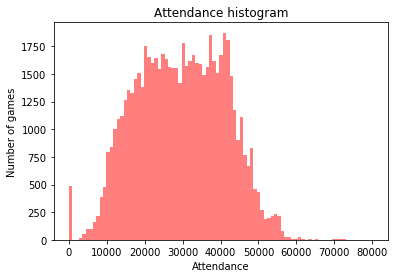

In [6]:
data['attendance'].hist(grid = False, color = 'r', bins = 'auto', alpha=0.5)
plt.xlabel('Attendance')
plt.ylabel('Number of games')
plt.title('Attendance histogram')
plt.show()

we can see that we have about 500 games with 0 attendance

In [7]:
data[data['attendance']==0].head()

,season,date,number_of_game,day_of_week,visiting_team,visiting_team_league,visiting_team_game_number,home_team,home_team_league,home_team_game_number,visiting_team_runs,home_team_runs,game_time,completion_info,park_id,attendance,visiting_team_hits,visiting_team_home_runs,home_team_hits,home_team_home_runs,winning_pitcher_id,winning_pitcher_name,losing_pitcher_id,losing_pitcher_name,saving_pitcher_id,saving_pitcher_name,game_winning_rbi_batter_id,game_winning_rbi_batter_name,visiting_pitcher_id,visiting_pitcher_name,home_pitcher_id,home_pitcher_name,visiting_player1_id,visiting_player1_name,visiting_player1_pos,visiting_player2_id,visiting_player2_name,visiting_player2_pos,visiting_player3_id,visiting_player3_name,visiting_player3_pos,visiting_player4_id,visiting_player4_name,visiting_player4_pos,visiting_player5_id,visiting_player5_name,visiting_player5_pos,visiting_player6_id,visiting_player6_name,visiting_player6_pos,visiting_player7_id,visiting_player7_name,visiting_player7_pos,visiting_player8_id,visiting_player8_name,visiting_player8_pos,visiting_player9_id,visiting_player9_name,visiting_player9_pos,home_player1_id,home_player1_name,home_player1_pos,home_player2_id,home_player2_name,home_player2_pos,home_player3_id,home_player3_name,home_player3_pos,home_player4_id,home_player4_name,home_player4_pos,home_player5_id,home_player5_name,home_player5_pos,home_player6_id,home_player6_name,home_player6_pos,home_player7_id,home_player7_name,home_player7_pos,home_player8_id,home_player8_name,home_player8_pos,home_player9_id,home_player9_name,home_player9_pos,acquisition_info
24,1990,4/11/1990,1,Wed,SFN,NL,1,ATL,NL,1,8,0,N,NaN,ATL01,0.0,13,2,3,0,reusr001,Rick Reuschel,glavt001,Tom Glavine,NaN,(none),clarw001,Will Clark,reusr001,Rick Reuschel,glavt001,Tom Glavine,butlb001,Brett Butler,8,bassk001,Kevin Bass,9,clarw001,Will Clark,3,mitck001,Kevin Mitchell,7,willm003,Matt Williams,5,thomr003,Robby Thompson,4,cartg001,Gary Carter,2,uribj001,Jose Uribe,6,reusr001,Rick Reuschel,1,mcdoo001,Oddibe McDowell,8,treaj001,Jeff Treadway,4,gregt001,Tommy Gregg,7,esasn001,Nick Esasky,3,murpd001,Dale Murphy,9,white002,Ernie Whitt,2,presj001,Jim Presley,5,blauj001,Jeff Blauser,6,glavt001,Tom Glavine,1,Y
35,1990,4/12/1990,1,Thu,PHI,NL,2,CHN,NL,2,5,4,D,NaN,CHI11,0.0,7,0,9,1,mulht001,Terry Mulholland,wilss001,Steve Wilson,mcdor001,Roger McDowell,thond001,Dickie Thon,mulht001,Terry Mulholland,wilss001,Steve Wilson,camps001,Sil Campusano,8,herrt001,Tom Herr,4,martc001,Carmelo Martinez,7,jordr001,Ricky Jordan,3,hayev001,Von Hayes,9,thond001,Dickie Thon,6,lakes001,Steve Lake,2,hayec001,Charlie Hayes,5,mulht001,Terry Mulholland,1,waltj001,Jerome Walton,8,sandr001,Ryne Sandberg,4,mccll001,Lloyd McClendon,7,dawsa001,Andre Dawson,9,gracm001,Mark Grace,3,salal001,Luis Salazar,5,dunss001,Shawon Dunston,6,giraj001,Joe Girardi,2,wilss001,Steve Wilson,1,Y
293,1990,5/5/1990,1,Sat,SDN,NL,22,CHN,NL,22,2,3,D,NaN,CHI11,0.0,8,0,7,1,maddg002,Greg Maddux,leffc001,Craig Lefferts,NaN,(none),dunss001,Shawon Dunston,benea001,Andy Benes,maddg002,Greg Maddux,alomr001,Roberto Alomar,4,gwynt001,Tony Gwynn,9,cartj001,Joe Carter,8,clarj001,Jack Clark,3,lynnf001,Fred Lynn,7,santb001,Benito Santiago,2,robeb002,Bip Roberts,5,tempg001,Garry Templeton,6,benea001,Andy Benes,1,wynnm001,Marvell Wynne,8,sandr001,Ryne Sandberg,4,smitd003,Dwight Smith,9,gracm001,Mark Grace,3,clard001,Dave Clark,7,salal001,Luis Salazar,5,dunss001,Shawon Dunston,6,giraj001,Joe Girardi,2,maddg002,Greg Maddux,1,Y
300,1990,5/6/1990,1,Sun,TEX,AL,24,CLE,AL,23,5,9,D,NaN,CLE07,0.0,8,3,12,4,candt001,Tom Candiotti,bohab001,Brian Bohanon,orosj001,Jesse Orosco,baerc001,Carlos Baerga,bohab001,Brian Bohanon,candt001,Tom Candiotti,husoj001,Jeff Huson,6,palmr001,Rafael Palmeiro,3,franj002,Julio Franco,4,sierr001,Ruben Sierra,9,bainh001,Harold Baines,10,incap001,Pete Incaviglia,7,petrg001,Geno Petralli,2,cools001,Scott Coolbaugh,5,pettg001,Gary Pettis,8,websm001,Mitch Webster,8,browj001,Jerry Browne,4,baerc001,Carlos Baerga,5,sn

we can see that all the games with 0 attendence have 1 in column "number_of_game":

In [8]:
data.loc[(data['attendance'] == 0) & (data['number_of_game'] !=1)].shape

(0, 87)

this happens when there are 2 games in a row and the audience can stay in the stadium. We can ignore these rows of data. __Since we will later create new features, such as player's statistics, which are cumulative and we want to take into account all the games along a season, we will keep the original data as is and ignore the missing values only before modeling__.

In [9]:
data_for_modeling = data[data['attendance']!=0]

We also have 3 missing attendance values, since it is only 3 we will ignore them:

In [10]:
np.sum(data_for_modeling.isnull())

season                              0
date                                0
number_of_game                      0
day_of_week                         0
visiting_team                       0
visiting_team_league                0
visiting_team_game_number           0
home_team                           0
home_team_league                    0
home_team_game_number               0
visiting_team_runs                  0
home_team_runs                      0
game_time                           1
completion_info                 64801
park_id                             0
attendance                          3
visiting_team_hits                  0
visiting_team_home_runs             0
home_team_hits                      0
home_team_home_runs                 0
winning_pitcher_id                 13
winning_pitcher_name               13
losing_pitcher_id                  13
losing_pitcher_name                13
saving_pitcher_id               31965
saving_pitcher_name                 0
game_winning

In [11]:
data_for_modeling = data_for_modeling[data_for_modeling.attendance.notnull()]

## Initial Data enrichment and cleaning
The initial data is lacking very basic features, so let's get them.
<br>
_divisions_ - team's division (east/west/center) (categorical)
<br>
_loss count_ - the number of losses this season up until this game (numeric)
<br>
_park capacity_ - official number, attendance can sometimes be higher than the park capacity (numeric)

In [12]:
data_as_dict = data.to_dict("records")
type_fix(data_as_dict)
fix_team_names(data_as_dict)
divisions(data_as_dict)
loss_count(data_as_dict)
park_capacity(data_as_dict)
data = pd.DataFrame().from_records(data_as_dict)

data_for_modeling = data[data['attendance']!=0]
data_for_modeling = data_for_modeling[data_for_modeling.attendance.notnull()]

<font color=blue>__in-data correlation__</font>

We will show correlations only between some features (because of visibility reasons)

In [13]:
data1=data_for_modeling[['season','date','number_of_game','day_of_week','visiting_team','visiting_team_league','visiting_team_division','visiting_team_game_number','home_team','home_team_league','home_team_division','home_team_game_number','visiting_team_runs','home_team_runs','winning_team','visiting_team_loss_count','home_team_loss_count','game_time','park_id','park_capacity','attendance']]

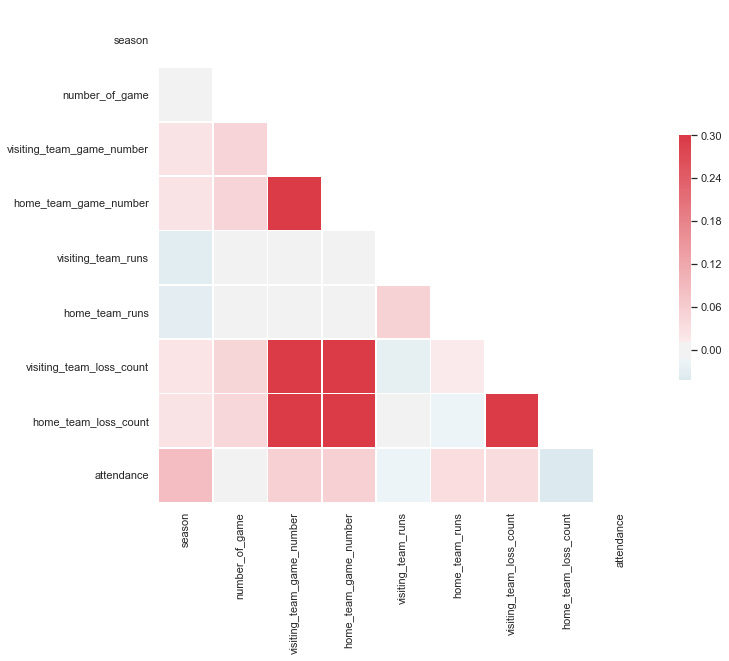

In [14]:
corr = data1.corr()
sns.set(style="white")
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

As can be seen in the last line of the table, no feature affects the attendance dramatically on its own

<font color=blue>__trends over time of week__</font>

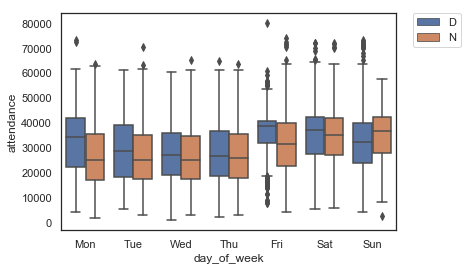

In [15]:
order = ['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun']
data1 = data_for_modeling[['day_of_week','game_time','attendance' ]]
sns.boxplot(x='day_of_week', y='attendance',data=data1, order=order,hue='game_time')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

we can see a slight difference between weekdays and weekends and between day (D) and night (N) games.

<font color=blue>__Home team influence__</font>

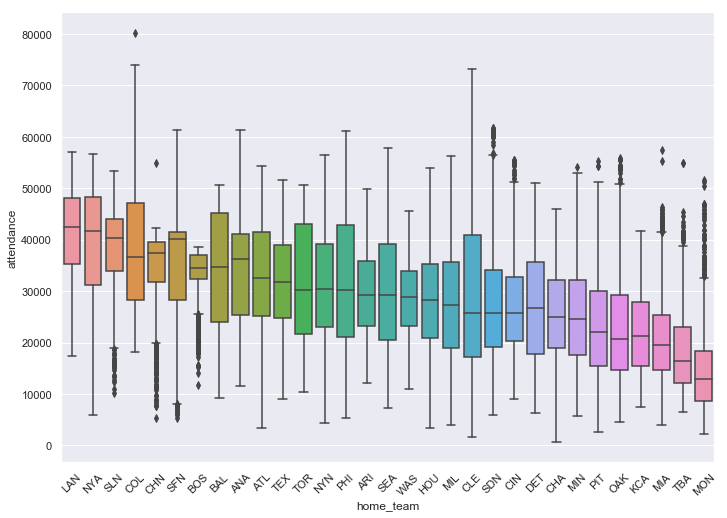

In [16]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
order = data_for_modeling.groupby(by=["home_team"])["attendance"].mean().sort_values()[::-1].index
ax = sns.boxplot(x='home_team', y='attendance', data=data_for_modeling, order = order)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

We can see a general trend along the home teams. We can also see that BOS has very little variance comparing to CLE.

## Modeling
### Basic data & basic models

We will start from one global parametric model - linear regression and one local nonparametric model - KNN regression.
We drop all the 'after game time' variables which obviously did not influence the number of attendance (such as the winning team or the hit counts), we will convert all the categorical variables to one-hot encoding. 
__Since encoding the player's lineup variables result in a huge dimension, we will ignore the players for now and think of a way to reduce the dimensionality while still using this data.__

<font color=blue>__Linear regression__</font>

In [17]:
# treat the days as categorial data 
data_for_modeling['day_of_week'] = data_for_modeling['day_of_week'].astype('category')
data_for_modeling['day_of_week'] = data_for_modeling['day_of_week'].cat.reorder_categories(['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'], ordered=True)
data_for_modeling['day_of_week'] = data_for_modeling['day_of_week'].cat.codes

# one-hot encoding for the visiting team and home team
oh_visiting_team = pd.get_dummies(data_for_modeling['visiting_team'],prefix='visiting_team')
oh_home_team = pd.get_dummies(data_for_modeling['home_team'],prefix='home_team')

# treat the leagues as categorial data 
cats = data_for_modeling[['visiting_team_league','home_team_league']].stack().sort_values().unique()
data_for_modeling['visiting_team_league'] = pd.Categorical(data_for_modeling['visiting_team_league'], categories=cats)
data_for_modeling['home_team_league'] = pd.Categorical(data_for_modeling['home_team_league'], categories=cats)
data_for_modeling[['visiting_team_league','home_team_league']] = data_for_modeling[['visiting_team_league','home_team_league']].apply(lambda x: x.cat.codes)

# one-hot encoding for the team's division
oh_visiting_team_division = pd.get_dummies(data_for_modeling['visiting_team_division'],prefix='visiting_team_division')
oh_home_team_division = pd.get_dummies(data_for_modeling['home_team_division'],prefix='home_team_division')

# treat the game time as categorial data 
data_for_modeling['game_time'] = data_for_modeling['game_time'].astype('category')
data_for_modeling['game_time'] = data_for_modeling['game_time'].cat.codes

# one-hot encoding for the park ids
oh_park_id = pd.get_dummies(data_for_modeling['park_id'],prefix='park_id')

Y = data_for_modeling["attendance"]

# drop post-game features and players ids and names
post_game_features_and_players = ['home_player9_id','home_player8_id','home_player7_id','home_player6_id','home_player5_id','home_player4_id',
             'home_player3_id','home_player2_id','home_player1_id','visiting_player9_id','visiting_player8_id','visiting_player7_id',
             'visiting_player6_id','visiting_player5_id','visiting_player4_id','visiting_player3_id','visiting_player2_id','visiting_player1_id',
             'home_pitcher_id','visiting_pitcher_id','park_id','home_team_division','visiting_team_division','home_team','visiting_team',
             'attendance','winning_team','completion_info','visiting_team_runs','home_team_runs','visiting_team_hits','visiting_team_home_runs','home_team_hits',
             'home_team_home_runs','home_team_home_runs','winning_pitcher_id','winning_pitcher_name','losing_pitcher_id',
             'losing_pitcher_name','saving_pitcher_id','saving_pitcher_name','game_winning_rbi_batter_id','game_winning_rbi_batter_name',
             'visiting_pitcher_name','home_pitcher_name','visiting_player1_name','visiting_player2_name','visiting_player3_name',
             'visiting_player4_name','visiting_player5_name','visiting_player6_name','visiting_player7_name','visiting_player8_name',
             'visiting_player9_name','home_player1_name','home_player2_name','home_player3_name','home_player4_name',
             'home_player5_name','home_player6_name','home_player7_name','home_player8_name','home_player9_name','acquisition_info',
             'visiting_pitcher_id','home_pitcher_id','visiting_player1_id','visiting_player2_id','visiting_player3_id','visiting_player3_id',
             'visiting_player4_id','visiting_player5_id','visiting_player6_id','visiting_player7_id','visiting_player8_id','visiting_player9_id',
             'home_player1_id','home_player2_id','home_player3_id','home_player4_id','home_player5_id','home_player6_id','home_player7_id',
             'home_player8_id','home_player9_id']
X = data_for_modeling.drop(post_game_features_and_players,axis=1)
X = pd.concat([X,oh_visiting_team,oh_home_team,oh_visiting_team_division,oh_home_team_division,oh_park_id],axis=1)
#convert the date to date type
X['date'] = pd.to_datetime(X['date'])
X['date']=X['date'].map(datetime.toordinal)

In [18]:
print("data dimensions after first enrichment and one-hot encoding", X.shape)

data dimensions after first enrichment and one-hot encoding (64836, 160)


In [19]:
lm = linear_model.LinearRegression()
score = cross_val_score(lm, X, Y, cv=10, scoring='neg_mean_squared_error')
print ("The RMSE score for 10-fold cross validation is ", np.sqrt(score.mean()*-1))
lm.fit(X,Y)
print ("The R^2 score is ", lm.score(X,Y))

The RMSE score for 10-fold cross validation is  8834.238224103754
The R^2 score is  0.48153729996680705


In [20]:
res = feature_selection.f_regression(X, Y)
params = pd.Series(res[1], index=X.columns)
print("the most significant features are: (p-values)")
print(params.sort_values()[:10])
print("the least significant features are:(p-values)")
print(params.sort_values()[-10:])

the most significant features are: (p-values)
home_team_NYA     0.000000e+00
home_team_LAN     0.000000e+00
home_team_MON     0.000000e+00
home_team_TBA     0.000000e+00
park_id_MON02     0.000000e+00
park_id_LOS03     0.000000e+00
day_of_week       0.000000e+00
park_id_STP01     0.000000e+00
home_team_SLN    1.751128e-289
home_team_MIA    6.880876e-276
dtype: float64
the least significant features are:(p-values)
park_id_MNT01               0.280393
park_id_SYD01               0.292785
home_player1_pos            0.314740
park_id_ATL03               0.344728
park_id_SAN02               0.385980
visiting_team_division_E    0.464431
home_team_SEA               0.471358
visiting_player5_pos        0.645760
home_player6_pos            0.871319
visiting_team_OAK           0.968143
dtype: float64


<font color=blue>__KNN regression__</font>

100%|██████████| 15/15 [10:13<00:00, 43.11s/it]


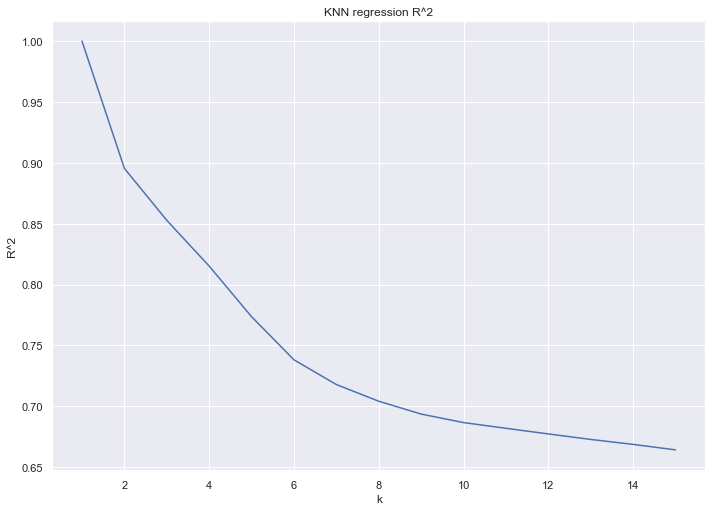

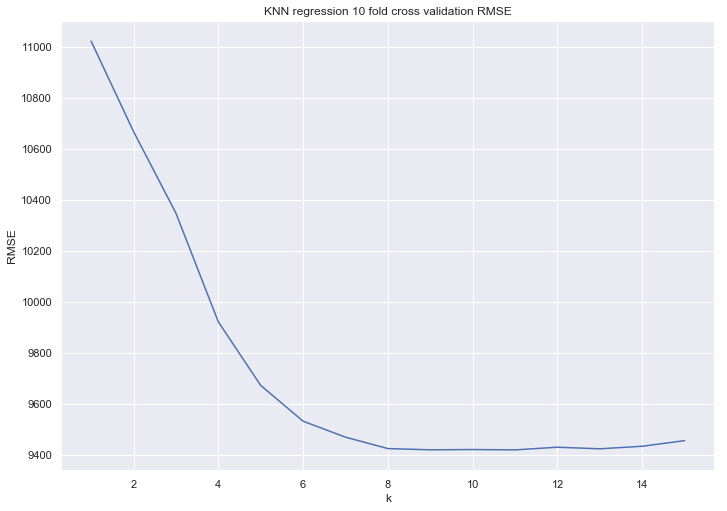

the best result is for K= 11  with RMSE =  9419.517857958823  and R^2 =  0.6818207382263568


In [21]:
r2=[0 for i in range(15)]
rmse=[0 for i in range(15)]

for i in tqdm(range(1,16)):
    neigh = KNeighborsRegressor(n_neighbors=i)
    score = cross_val_score(neigh, X, Y, cv=10, scoring='neg_mean_squared_error')
    rmse[i-1] = np.sqrt(score.mean()*-1)
    neigh.fit(X,Y)
    r2[i-1] = neigh.score(X,Y)
    
plt.plot([i for i in range(1,16)],r2)
plt.ylabel('R^2')
plt.xlabel('k')
plt.title('KNN regression R^2')
plt.show()

plt.plot([i for i in range(1,16)],rmse)
plt.ylabel('RMSE')
plt.xlabel('k')
plt.title('KNN regression 10 fold cross validation RMSE')
plt.show()

best = np.argmin(rmse)
print("the best result is for K=", best+1, " with RMSE = ", rmse[best], " and R^2 = ", r2[best])

As can be seen, both linear and KNN regression do not perform very well. We need to integrate external data and engineer new features.

## Feature Engineering
__Integrations__: 
<br>
- _holidays_ - 1 if Opening Day (first home game of the year), July 4th (in US), Labor Day, Memorial Day, Canada day (in Canada) (boolean)
<br>
- _rivalry_  - 1 if the game is between local/historic rivals. For instance 2 teams from the same city or the famous New York Yankees vs Boston Red Sox (boolean)
<br>
- _weather_  - 3 new features: wind speed, temperture and condition score (enumeration of weather condition. no clouds/in dome=0, cloudy/overcast=1, rain=3,snow/hail=5) (numeric)
<br>
- _salary_ - 3 new features (for each team): yearly max and avarege salary of lineup players and starting pitcher salary. Normalized against all salaries in a given season. (numeric)

__Feature Engineering__:
<br>
- _streaks_  - number of winning(positive)/lossing(negative) games in a row until the current game for each team(numeric)
<br>
- _intradivision_ - 1 if game was between two teams from the same division and league, 0 otherwise (boolean)
<br>
- _interleague_ - 1 if the game is between teams from opposite leagues. (boolean) 
<br>
- _players statistics_ - 6 new features (for each team): max slugging percentage, avarege slugging percentage, max on-base plus slugging, avarege on-base plus slugging, starting pitcher earned run average, starting pitcher win probability added. All the features are normalized against all other player's statistcs for that game number, in that season. These features are meant to indicate the presence of "star" players and overall team gameplay quality (numeric)
<br>
- _games behind_ - difference in number of losses between a given team and the first place team in its division, for each team(numeric)
<br>
- _rank in division_ - team's rank (1st/2nd,3rd…) in its division prior to the game, for each team (numeric)

In [22]:
data_as_dict = data.to_dict("records")
weather(data_as_dict)
holiday(data_as_dict)
rivalry(data_as_dict)
interleague(data_as_dict)
intradivision(data_as_dict)
cumulative_metric(data_as_dict, 'runs')
cumulative_metric(data_as_dict, 'hits')
cumulative_metric(data_as_dict, 'home_runs')
streaks(data_as_dict)
standings(data_as_dict)
salary(data_as_dict)
player_stats(data_as_dict)
data = pd.DataFrame().from_records(data_as_dict)

data_for_modeling = data[data['attendance']!=0]
data_for_modeling = data_for_modeling[data_for_modeling.attendance.notnull()]

### Converting to prediction of bins
Since papers have found that an increase in 1000 spectators results in 10.74 annual hours of traffic delay, we have decided to focus on predicting MLB attendance by bins of 1000.

In [23]:
data_for_modeling['attendance_in_thousands'] = data_for_modeling['attendance'].apply(lambda x: int(round(x, -3)/1000))

## Modeling
### Augmented Data & basic models

In [24]:
# treat the days as categorial data 
data_for_modeling['day_of_week'] = data_for_modeling['day_of_week'].astype('category')
data_for_modeling['day_of_week'] = data_for_modeling['day_of_week'].cat.reorder_categories(['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'], ordered=True)
data_for_modeling['day_of_week'] = data_for_modeling['day_of_week'].cat.codes

# one-hot encoding for the visiting team
oh_visiting_team = pd.get_dummies(data_for_modeling['visiting_team'],prefix='visiting_team')
oh_home_team = pd.get_dummies(data_for_modeling['home_team'],prefix='home_team')

# treat the leagues as categorial data 
cats = data_for_modeling[['visiting_team_league','home_team_league']].stack().sort_values().unique()
data_for_modeling['visiting_team_league'] = pd.Categorical(data_for_modeling['visiting_team_league'], categories=cats)
data_for_modeling['home_team_league'] = pd.Categorical(data_for_modeling['home_team_league'], categories=cats)
data_for_modeling[['visiting_team_league','home_team_league']] = data_for_modeling[['visiting_team_league','home_team_league']].apply(lambda x: x.cat.codes)

# one-hot encoding for the team's division
oh_visiting_team_division = pd.get_dummies(data_for_modeling['visiting_team_division'],prefix='visiting_team_division')
oh_home_team_division = pd.get_dummies(data_for_modeling['home_team_division'],prefix='home_team_division')

# treat the game time as categorial data 
data_for_modeling['game_time'] = data_for_modeling['game_time'].astype('category')
data_for_modeling['game_time'] = data_for_modeling['game_time'].cat.codes

# one-hot encoding for the park ids
oh_park_id = pd.get_dummies(data_for_modeling['park_id'],prefix='park_id')

Y = data_for_modeling['attendance_in_thousands']

X = data_for_modeling.drop(post_game_features_and_players+['attendance_in_thousands'],axis=1)
X = pd.concat([X,oh_visiting_team,oh_home_team,oh_visiting_team_division,oh_home_team_division,oh_park_id],axis=1)
#convert the date to date type
X['date'] = pd.to_datetime(X['date'])
X['date']=X['date'].map(datetime.toordinal)

In [25]:
print("data dimensions after second enrichment and one-hot encoding", X.shape)

data dimensions after second enrichment and one-hot encoding (64836, 207)


<font color=blue>__Linear regression__</font>

In [26]:
lm = linear_model.LinearRegression()
score = cross_val_score(lm, X, Y, cv=10, scoring='neg_mean_squared_error')
print ("The RMSE score for 10-fold cross validation is ", np.sqrt(score.mean()*-1))
lm.fit(X,Y)
print ("The R^2 score is ", lm.score(X,Y))

The RMSE score for 10-fold cross validation is  8.043812509564624
The R^2 score is  0.5680814359643209


In [27]:
res = feature_selection.f_regression(X, Y)
params = pd.Series(res[1], index=X.columns)
print("the most significant features are: (p-values)")
print(params.sort_values()[:10])
print("the least significant features are:(p-values)")
print(params.sort_values()[-10:])

the most significant features are: (p-values)
park_id_MON02                     0.0
park_id_LOS03                     0.0
rivalry                           0.0
home_team_LAN                     0.0
home_team_rank_in_division        0.0
home_team_games_behind            0.0
home_team_NYA                     0.0
home_team_avg_slg_normalized      0.0
home_team_avg_ops_normalized      0.0
home_starter_salary_normalized    0.0
dtype: float64
the least significant features are:(p-values)
park_id_MNT01               0.291626
park_id_SYD01               0.302273
park_id_ATL03               0.331884
home_player1_pos            0.346083
park_id_SAN02               0.388342
home_team_SEA               0.448971
visiting_team_division_E    0.473277
visiting_player5_pos        0.632695
home_player6_pos            0.901998
visiting_team_OAK           0.944652
dtype: float64


Many of our new features are among the most significant ones!

<font color=blue>__Ridge regression__</font>


100%|██████████| 15/15 [02:46<00:00, 11.11s/it]


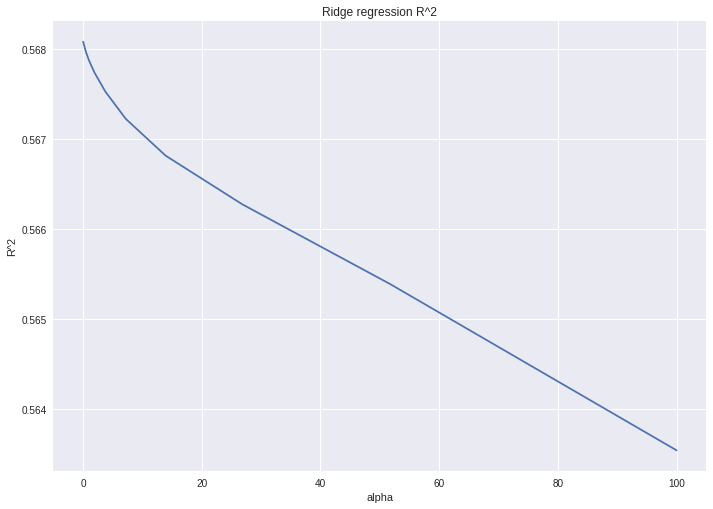

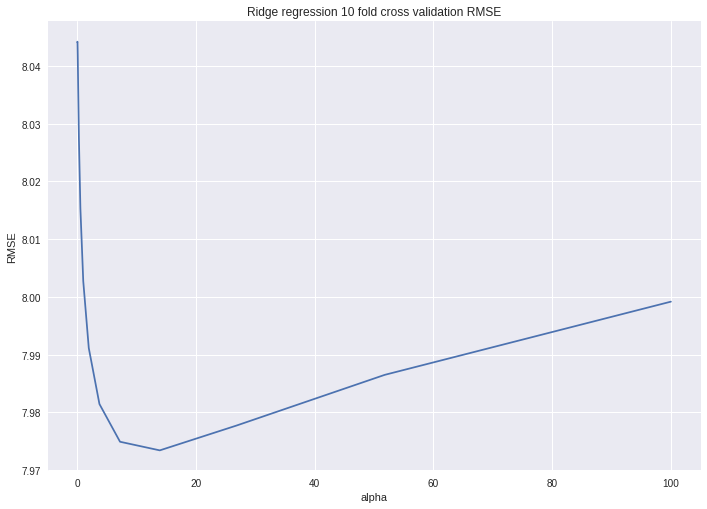

the best result is for alpha= 13.894954943731374  with RMSE =  7.973440058734532  and R^2 =  0.566816834657891


In [51]:
r2=[0 for i in range(15)]
rmse=[0 for i in range(15)]
n_alphas = 15
alphas = np.logspace(-2, 2, n_alphas)

for i in tqdm(range(0,15)):
    ridg = Ridge(alpha = alphas[i])
    score = cross_val_score(ridg, X, Y, cv=10, scoring='neg_mean_squared_error')
    rmse[i] = np.sqrt(score.mean()*-1)
    ridg.fit(X,Y)
    r2[i] = ridg.score(X,Y)
    
plt.plot(alphas,r2)
plt.ylabel('R^2')
plt.xlabel('alpha')
plt.title('Ridge regression R^2')
plt.show()

plt.plot(alphas,rmse)
plt.ylabel('RMSE')
plt.xlabel('alpha')
plt.title('Ridge regression 10 fold cross validation RMSE')
plt.show()

best = np.argmin(rmse)
print("the best result is for alpha=", alphas[best], " with RMSE = ", rmse[best], " and R^2 = ", r2[best])

<font color=blue>__Lasso regression__</font>


100%|██████████| 15/15 [25:45<00:00, 53.92s/it]


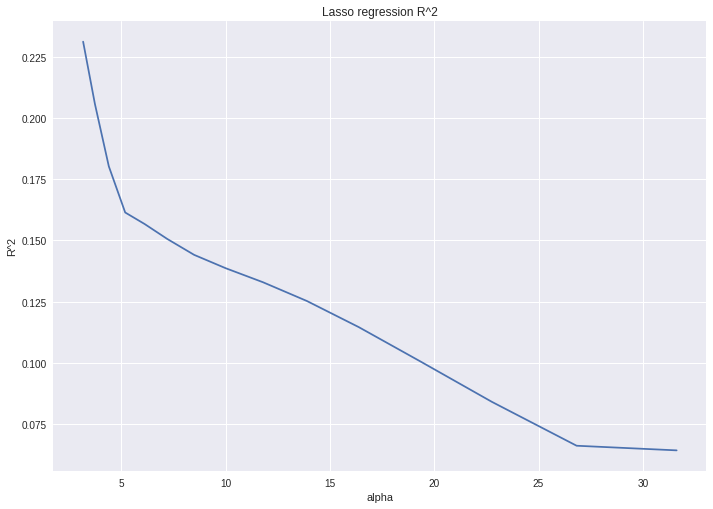

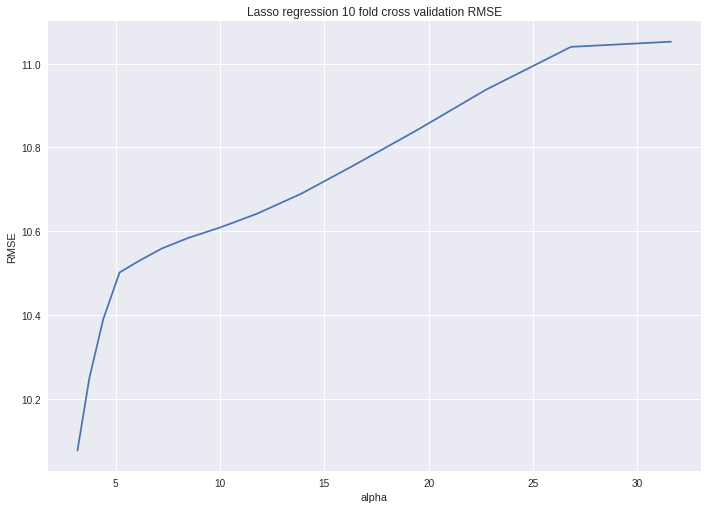

the best result is for alpha= 3.1622776601683795  with RMSE =  10.076163254127346  and R^2 =  0.23123853006754425


In [52]:
r2=[0 for i in range(15)]
rmse=[0 for i in range(15)]
n_alphas = 15
alphas = np.logspace(0.5,1.5, n_alphas)

for i in tqdm(range(0,15)):
    lass = Lasso(alpha = alphas[i])
    score = cross_val_score(lass, X, Y, cv=10, scoring='neg_mean_squared_error')
    rmse[i] = np.sqrt(score.mean()*-1)
    lass.fit(X,Y)
    r2[i] = lass.score(X,Y)
    
plt.plot(alphas,r2)
plt.ylabel('R^2')
plt.xlabel('alpha')
plt.title('Lasso regression R^2')
plt.show()

plt.plot(alphas,rmse)
plt.ylabel('RMSE')
plt.xlabel('alpha')
plt.title('Lasso regression 10 fold cross validation RMSE')
plt.show()

best = np.argmin(rmse)
print("the best result is for alpha=", alphas[best], " with RMSE = ", rmse[best], " and R^2 = ", r2[best])

from both ridge and lasso, we understand that regularization does not improve our results. We will have to try different methods in order to reduce dimensionality.

<font color=blue>__KNN Classification__</font>

since we now predict in bins of 1K, we want to use classification instead of regression.
But some of the class are very small so we cannot use k-fold cross-validation.
We will implement semi-cross validation by randomly divide the data 10 times to train and test


100%|██████████| 15/15 [13:18<00:00, 58.19s/it]


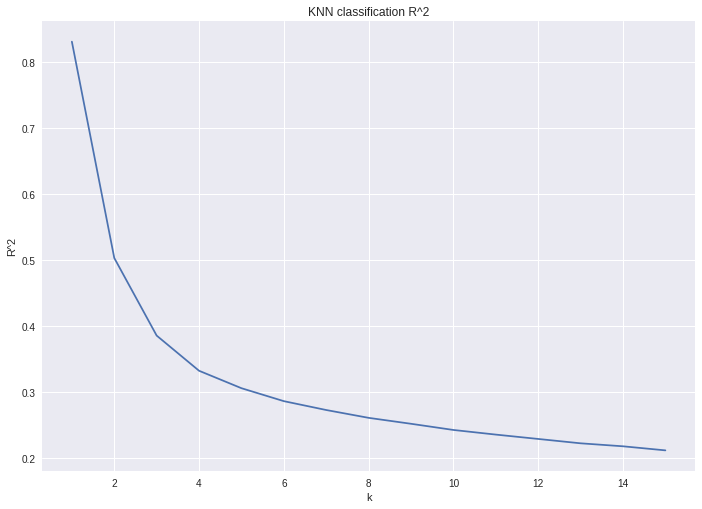

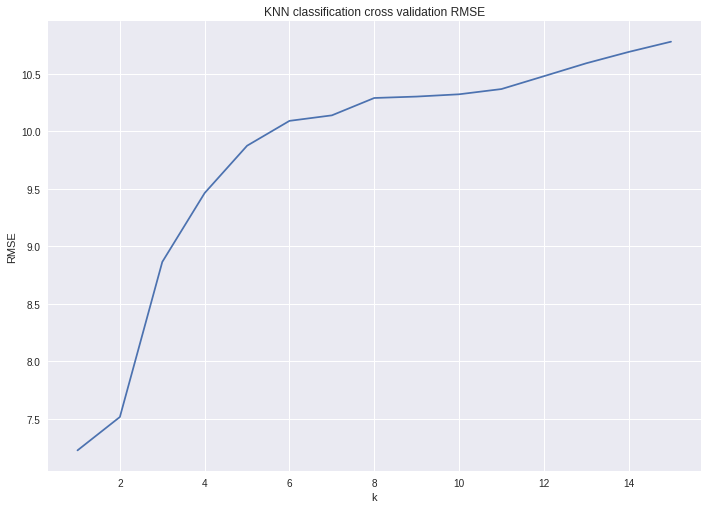

the best result is for k= 1  with RMSE =  7.225836778952508  and R^2 =  0.8304799802578814


In [53]:
r2=[0 for i in range(15)]
rmse=[0 for i in range(15)]

for i in tqdm(range(1,16)):
    score=[]
    for j in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
        neigh = KNeighborsClassifier(n_neighbors=i)
        neigh.fit(X_train, y_train)
        pred = neigh.predict(X_test)
        pred = pd.DataFrame(pred)
        pred['round'] = pred[0]
        pred = pred['round']
        pred = pd.DataFrame(pred)
        y_test=pd.DataFrame(y_test)
        df1 = pd.DataFrame(y_test.attendance_in_thousands.tolist())
        df2 = pd.DataFrame(pred['round'].tolist())
        df = pd.concat([df1,df2],axis=1)
        df.columns=['a','b']
        score.append(((df['a']-df['b']) ** 2).mean() ** .5)
    rmse[i-1]= sum(score)/10
    r2[i-1] = neigh.score(X,Y)

plt.plot([i for i in range(1,16)],r2)
plt.ylabel('R^2')
plt.xlabel('k')
plt.title('KNN classification R^2')
plt.show()

plt.plot([i for i in range(1,16)],rmse)
plt.ylabel('RMSE')
plt.xlabel('k')
plt.title('KNN classification cross validation RMSE')
plt.show()

best = np.argmin(rmse)
print("the best result is for k=", best+1, " with RMSE = ", rmse[best], " and R^2 = ", r2[best])

<font color=blue>__PCA and linear regression__</font>


100%|██████████| 5/5 [00:50<00:00, 10.43s/it]


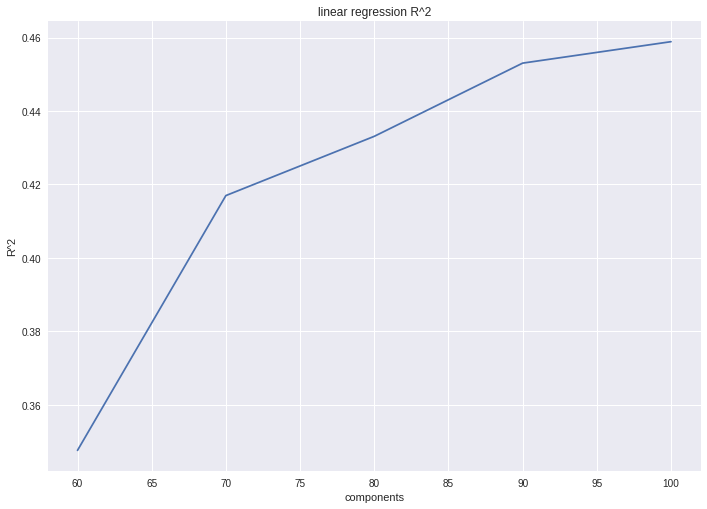

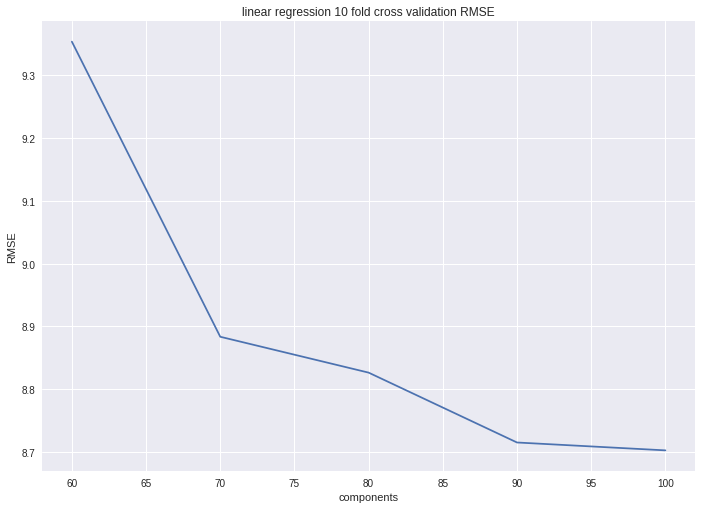

the best result is for  100 components with RMSE =  8.702321953477036  and R^2 =  0.4588722144352073


In [54]:
r2=[0 for i in range(5)]
rmse=[0 for i in range(5)]
components = [i for i in range(60,110,10)]

for i in tqdm(range(5)):
    pca = PCA(n_components=components[i])
    X_pca = pca.fit_transform(X)
    lm = linear_model.LinearRegression()
    score = cross_val_score(lm, X_pca, Y, cv=10, scoring='neg_mean_squared_error')
    rmse[i] = np.sqrt(score.mean()*-1)
    lm.fit(X_pca,Y)
    r2[i] = lm.score(X_pca,Y)
    
plt.plot(components,r2)
plt.ylabel('R^2')
plt.xlabel('components')
plt.title('linear regression R^2')
plt.show()

plt.plot(components,rmse)
plt.ylabel('RMSE')
plt.xlabel('components')
plt.title('linear regression 10 fold cross validation RMSE')
plt.show()

best = np.argmin(rmse)
print("the best result is for ",components[best] , "components with RMSE = ", rmse[best], " and R^2 = ", r2[best])

Again we can see that the RMSE decreases as we use more components, that is returning to the original dimension. 
<br>
Since it is clear that the new features did improve the overall performers, they are correlated to the response and there is no redundancy of features, we now change our strategy and try to add even more informative features while handling regularization and dimensionality reduction in other ways.

## Feature Engineering
We go back to add more fetures. 
<br>
__Feature Engineering__:
<br>
- _contention score_ - probability of reaching the playoffs given the teams rank in the division, current win record and number of games left to the season. (numeric)

__Integrations__: 
<br>
- _ticket price_  - average regular game ticket price (USD not adjusted for inflation) for that team/season. Normalized against average ticket prices for all teams in each season (numeric)
<br>
- _player age_  - 2 new features (for each team): average and max player's age. when age is the total number of games to date a player has appeared in an opening lineup. Normalized against player ages for all players/games. (numeric)

In [ ]:
data_as_dict = data.to_dict("records")
contention_score(data_as_dict)
ticket_price(data_as_dict)
player_age(data_as_dict)
data = pd.DataFrame().from_records(data_as_dict)

data_for_modeling = data[data['attendance']!=0]
data_for_modeling = data_for_modeling[data_for_modeling.attendance.notnull()]

## Modeling
### attempts to reduce dimensionality

#### different model for each home team

In [ ]:
data_for_modeling['attendance_in_thousands'] = data_for_modeling['attendance'].apply(lambda x: int(round(x, -3)/1000))

# treat the days as categorial data 
data_for_modeling['day_of_week'] = data_for_modeling['day_of_week'].astype('category')
data_for_modeling['day_of_week'] = data_for_modeling['day_of_week'].cat.reorder_categories(['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'], ordered=True)
data_for_modeling['day_of_week'] = data_for_modeling['day_of_week'].cat.codes

# one-hot encoding for the visiting team
oh_visiting_team = pd.get_dummies(data_for_modeling['visiting_team'],prefix='visiting_team')

# treat the leagues as categorial data 
cats = data_for_modeling[['visiting_team_league','home_team_league']].stack().sort_values().unique()
data_for_modeling['visiting_team_league'] = pd.Categorical(data_for_modeling['visiting_team_league'], categories=cats)
data_for_modeling['home_team_league'] = pd.Categorical(data_for_modeling['home_team_league'], categories=cats)
data_for_modeling[['visiting_team_league','home_team_league']] = data_for_modeling[['visiting_team_league','home_team_league']].apply(lambda x: x.cat.codes)

# one-hot encoding for the team's division
oh_visiting_team_division = pd.get_dummies(data_for_modeling['visiting_team_division'],prefix='visiting_team_division')
oh_home_team_division = pd.get_dummies(data_for_modeling['home_team_division'],prefix='home_team_division')

# treat the game time as categorial data 
data_for_modeling['game_time'] = data_for_modeling['game_time'].astype('category')
data_for_modeling['game_time'] = data_for_modeling['game_time'].cat.codes

# one-hot encoding for the park ids
oh_park_id = pd.get_dummies(data_for_modeling['park_id'],prefix='park_id')

post_game_features_and_players.remove('home_team')

X = data_for_modeling.drop(post_game_features_and_players,axis=1)
X = pd.concat([X,oh_visiting_team,oh_visiting_team_division,oh_home_team_division,oh_park_id],axis=1)
#convert the date to date type
X['date'] = pd.to_datetime(X['date'])
X['date']=X['date'].map(datetime.toordinal)

In [57]:
print("the dimension of data - a separate model for each team", X.shape)

the dimension of data - a separate model for each team (64836, 185)



100%|██████████| 31/31 [08:08<00:00, 14.93s/it]


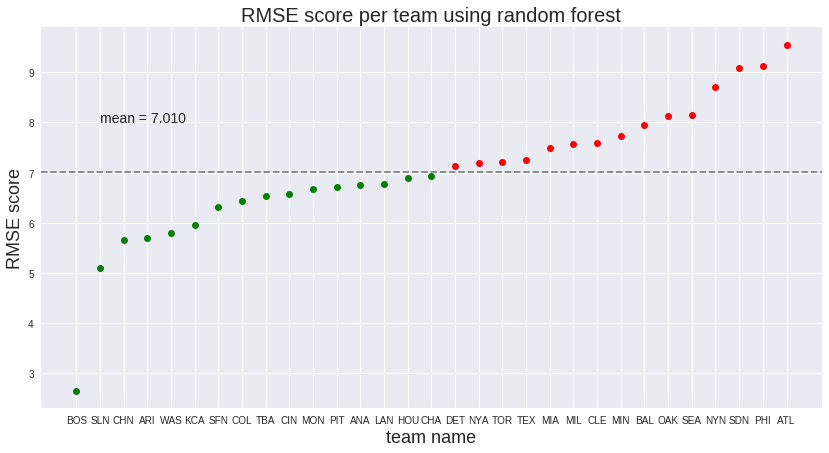

In [58]:
list_of_teams = list(set(X['home_team']))
rmse_per_team = [0 for i in range(len(list_of_teams))]
r2_per_team = [0 for i in range(len(list_of_teams))]
for i in tqdm(range(len(list_of_teams))):
    df_per_team = X[X['home_team'] == list_of_teams[i]]
    Y_per_team = df_per_team['attendance_in_thousands']
    X_per_team = df_per_team.drop(['attendance_in_thousands','home_team'], axis = 1)
    rdfr = RandomForestRegressor(n_estimators = 20)
    score = cross_val_score(rdfr, X_per_team, Y_per_team, cv=10, scoring='neg_mean_squared_error')
    rmse_per_team[i] = np.sqrt(score.mean()*-1)
    rdfr.fit(X_per_team,Y_per_team)
    r2_per_team[i] = rdfr.score(X_per_team,Y_per_team)

#sort by rmse values and plot
new_df = pd.DataFrame({'team':list_of_teams, 'rmse':rmse_per_team, 'r2':r2_per_team})
new_df = new_df.sort_values(by = ['rmse'])
sort_rmse = new_df.rmse.tolist()
mean = new_df['rmse'].mean()
#mask above and below the mean 
mask_above = ma.masked_less(sort_rmse, mean)
mask_below = ma.masked_greater(sort_rmse, mean)
plt.figure(figsize = (14,7))
plt.axhline(y=mean, color='gray', linestyle='--')
plt.plot(new_df['team'], mask_above,'ro' )
plt.plot(new_df['team'], mask_below, 'go')
plt.ylabel('RMSE score', fontsize = 18)
plt.xlabel('team name',fontsize = 18)
textstr ="mean = " +str("%.3f" % mean)
plt.text(1, int(mean)+1, textstr, fontsize =14)
plt.title('RMSE score per team using random forest', fontsize =20)

plt.show()


There is a high variation between the performers on different teams. For example, the model for team 'BOS' is very good while the one for the team 'CLE' is among the poor models. This makes sense when we remember the differences in attendece's distributions between the two teams as was shown earlier in the database analysis process.

Since the models are not stable, we go back to creating one model for the entire data.

#### using trees based methods - Random forest
In order to reduce dimensionality, we will not use one hot encoding, instead we use methods that can handle categorical variables.

In [ ]:
data_for_modeling = data[data['attendance']!=0]
data_for_modeling = data_for_modeling[data_for_modeling.attendance.notnull()]
data_for_modeling['attendance_in_thousands'] = data_for_modeling['attendance'].apply(lambda x: int(round(x, -3)/1000))
# treat the days as categorial data 
data_for_modeling['day_of_week'] = data_for_modeling['day_of_week'].astype('category')
data_for_modeling['day_of_week'] = data_for_modeling['day_of_week'].cat.reorder_categories(['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'], ordered=True)
data_for_modeling['day_of_week'] = data_for_modeling['day_of_week'].cat.codes

# treat the leagues as categorial data 
cats = data_for_modeling[['visiting_team_league','home_team_league']].stack().sort_values().unique()
data_for_modeling['visiting_team_league'] = pd.Categorical(data_for_modeling['visiting_team_league'], categories=cats)
data_for_modeling['home_team_league'] = pd.Categorical(data_for_modeling['home_team_league'], categories=cats)
data_for_modeling[['visiting_team_league','home_team_league']] = data_for_modeling[['visiting_team_league','home_team_league']].apply(lambda x: x.cat.codes)

# treat the game time as categorial data 
data_for_modeling['game_time'] = data_for_modeling['game_time'].astype('category')
data_for_modeling['game_time'] = data_for_modeling['game_time'].cat.codes

#do not drop the features that we used to one-hot
post_game_features_and_players.remove('visiting_team')
post_game_features_and_players.remove('visiting_team_division')
post_game_features_and_players.remove('home_team_division')
post_game_features_and_players.remove('park_id')

X = data_for_modeling.drop(post_game_features_and_players,axis=1)
#convert the date to date type
X['date'] = pd.to_datetime(X['date'])
X['date']=X['date'].map(datetime.toordinal)

In [60]:
print("final dimension of data (no one hot encoding)", X.shape)

final dimension of data (no one hot encoding) (64836, 90)


In [61]:
h2o.init()
h2oData = h2o.H2OFrame(X)
train,test = h2oData.split_frame(ratios=[0.8], seed = 1)
model = H2ORandomForestEstimator(nfolds=10, stopping_metric="RMSE", seed = 1)
training_columns = h2oData.columns
training_columns.remove('attendance_in_thousands')
response_column = 'attendance_in_thousands'
model.train(x=training_columns, y=response_column, training_frame=train)
performance = model.model_performance(test_data=test)

print (performance)
print ("R2: " + str(model.r2()))
h2o.cluster().shutdown()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "10.0.2" 2018-07-17; OpenJDK Runtime Environment (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.4); OpenJDK 64-Bit Server VM (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.4, mixed mode)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpdiwytdy7
  JVM stdout: /tmp/tmpdiwytdy7/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpdiwytdy7/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.4
H2O cluster version age:,4 days
H2O cluster name:,H2O_from_python_unknownUser_u2mfw2
H2O cluster total nodes:,1
H2O cluster free memory:,3 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%

ModelMetricsRegression: drf
** Reported on test data. **

MSE: 26.353988946401184
RMSE: 5.1336136343126935
MAE: 3.7786549844919297
RMSLE: 0.1977002904821377
Mean Residual Deviance: 26.353988946401184

R2: 0.777957341879252
H2O session _sid_b4b6 closed.


#### Gradient Boosting
our final attempt is to include boosting instead of bagging (random forest) in order to increase predictive force and to decrease bias.

In [63]:
h2o.init()
h2oData = h2o.H2OFrame(X)
train,test = h2oData.split_frame(ratios=[0.8], seed = 1)
grb = H2OGradientBoostingEstimator(ntrees=500, nfolds = 10, stopping_tolerance=0.06,balance_classes = True, seed = 1,
                                   stopping_metric = "rmse")
training_columns = h2oData.columns
training_columns.remove('attendance_in_thousands')
response_column = 'attendance_in_thousands'
grb.train(x=training_columns, y=response_column, training_frame=train)
performance = grb.model_performance(test_data=test)

print (performance)
print ("R2: " + str(grb.r2()))


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "10.0.2" 2018-07-17; OpenJDK Runtime Environment (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.4); OpenJDK 64-Bit Server VM (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.4, mixed mode)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpyxakpq4g
  JVM stdout: /tmp/tmpyxakpq4g/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpyxakpq4g/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.4
H2O cluster version age:,4 days
H2O cluster name:,H2O_from_python_unknownUser_fesdj5
H2O cluster total nodes:,1
H2O cluster free memory:,3 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 22.423580404280433
RMSE: 4.735354306097953
MAE: 3.46704167385258
RMSLE: 0.1791375350456192
Mean Residual Deviance: 22.423580404280433

R2: 0.893668657373426


## statistical evaluation

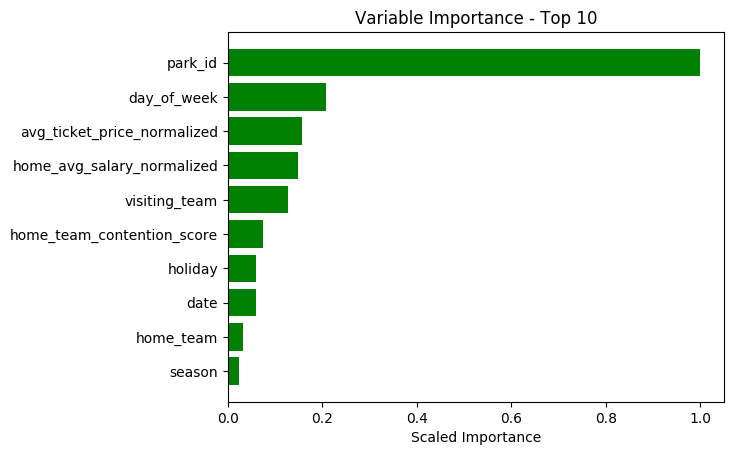

H2O session _sid_8992 closed.


In [64]:
plt.rcdefaults()
fig, ax = plt.subplots()
variables = grb._model_json['output']['variable_importances']['variable'][:10]
y_pos = np.arange(len(variables))
scaled_importance = grb._model_json['output']['variable_importances']['scaled_importance'][:10]
ax.barh(y_pos, scaled_importance, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance - Top 10')
plt.show()

h2o.cluster().shutdown()

## conclusion

Our best and final model is Gradient Boosting of trees that can handle categorical variables. 
<br>
The model uses a high number of tree but also a high stopping tolerance (helps to reduce overfitting). 
<br>
We hope you enjoyed reading the notebook as much as we enjoyed creating it. 
<br>
See you at the next baseball game! 
